## Attempt to run Kilosort2 via spike interfaces and using a probe geometry file
The data used for this purpose is on continuously sampled wideband data collected by Jimmie Gmaz. [(Source)](http://datasets.datalad.org/?dir=/labs/mvdm/BiconditionalOdor)

## Prerequisites
- Computer with NVIDIA GPU
- Install Matlab and compatible CUDA libraries
- Download Kilosort2 and compile all the MEX files in the 'CUDA folder'. For details follow the documentation on the [Kilosort2 repository.](https://github.com/MouseLand/Kilosort2/)


In [1]:
# Recommended import aliases: https://spikeinterface.readthedocs.io/en/latest/getting_started/plot_getting_started.html
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
# Additional imports
import os.path as op
import neo  # neo for some direct reading to check on # of segments etc
import numpy as np
import matplotlib.pyplot as plt
import os
import re

In [2]:
# sample_file can be any file in the directory which has ALL the ncs files.
# sample_file = 'data/BiconditionalOdor/M040-2020-04-28-CDOD11/CSC11.ncs'
sample_file = 'data/BiconditionalOdor/M040-2020-04-29-CDOD12/CSC11.ncs'
dname = (op.dirname(sample_file))
# print(dname)

# Throws an error if the the ncs files don't have the same length
# On omitting the file with a different length, this works (data/BiconditionalOdor/M040-2020-04-28-CDOD11/CSC26.ncs for instance)
# Or use the "exclude_files" keyword to explicitly a list of .Ncs files that are not meant for spike sorting or other_reasons
# NOTE: Clone and install neo from "https://github.com/manimoh/python-neo" for the 'exclude_files' feature to work

# reader = neo.NeuralynxIO(dirname=dname, exclude_files = ['CSC26.ncs'])
reader = neo.NeuralynxIO(dirname=dname)
print(reader)

NeuralynxIO: data/BiconditionalOdor/M040-2020-04-29-CDOD12
nb_block: 1
nb_segment:  [5]
signal_channels: [CSC10, CSC11, CSC12, CSC13 ... CSC30 CSC31 CSC32 CSC9]
unit_channels: [chTT3#13#0, chTT3#14#0, chTT3#8#0, chTT3#24#0 ... chTT8#3#0 chTT8#4#0 chTT8#19#0 chTT8#20#0]
event_channels: [Events event_id=11 ttl=0, Events event_id=11 ttl=1, Events event_id=11 ttl=2, Events event_id=11 ttl=4 ... Events event_id=11 ttl=48 Events event_id=11 ttl=64 Events event_id=11 ttl=96 Events event_id=19 ttl=0]



In [3]:
# recordingList = [se.NeuralynxRecordingExtractor(dirname=op.dirname(sample_file), exclude_files = ['CSC26.ncs'], seg_index=i) for i in range(reader.segment_count(0))]
recordingList = [se.NeuralynxRecordingExtractor(dirname=op.dirname(sample_file), seg_index=i) for i in range(reader.segment_count(0))]

# This concatenates mutiple segments together
recordingFull = se.MultiRecordingTimeExtractor(recordingList)

<table><tr>
<td> <img src="ks2_test/A4x2-tet-CM42-channelMap.png" alt="Drawing"/> </td>
<td> <img src="ks2_test/A4x2-tet-CM42-probeGeometry.png" alt="Drawing"/> </td>
</tr></table>
<table><tr>
<td> <img src="ks2_test/CM32-NN-to-neuralynx-mapping.JPG" alt="Drawing"/> </td>
</tr></table>

In [4]:
# Load probe file
recording_probe = recordingFull.load_probe_file('probe_files/NN_A4x2tet.prb')

In [5]:
# Adding labels (CSC names) to channels from neo Neuralynx header
for ad_ch in recording_probe.get_channel_ids():
    csc_idx = np.where(reader.header['signal_channels']['id'] == ad_ch)
#     print(reader.header['signal_channels']['name'][csc_idx])
    recording_probe.set_channel_property(ad_ch, 'label', reader.header['signal_channels']['name'][csc_idx][0])

In [6]:
# Assigning groups (TT num) to channels from neo Neuralynx header
for ch in reader.header['unit_channels']:
    tetrode = int(re.search('(?<=TT)(.*?)(?=#)', ch[0]).group(0))
    ad_ch = int(re.search('(?<=#)(.*?)(?=#)', ch[0]).group(0))
    recording_probe.set_channel_property(ad_ch, 'group', tetrode)

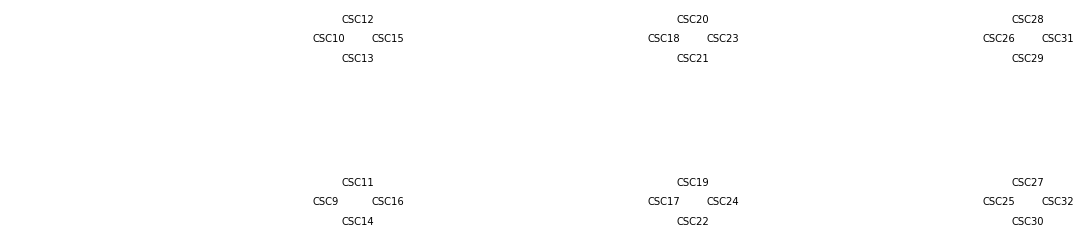

In [7]:
# Sanity check to see that the relative locations of the various channels match that of the images above
xcoords = [pos[0] for pos in recording_probe.get_channel_locations()]
ycoords = [pos[1] for pos in recording_probe.get_channel_locations()]
labels = [recording_probe.get_channel_property(i, 'label') for i in recording_probe.get_channel_ids()]
fig,ax = plt.subplots()
ax.axis('off')
for i in range(len(xcoords)):
    plt.text(xcoords[i]/200,ycoords[i]/200,labels[i])

In [8]:
# Transfer properties from recording probe to recordingFull
for ch in recordingFull.get_channel_ids():
    for prop in recording_probe.get_shared_channel_property_names():
        recordingFull.set_channel_property(ch, prop, recording_probe.get_channel_property(ch, prop))

In [9]:
# This should contain kilosort2
print (ss.available_sorters())

['hdsort', 'herdingspikes', 'ironclust', 'kilosort', 'kilosort2', 'klusta', 'mountainsort4', 'spykingcircus', 'tridesclous', 'waveclus']


In [10]:
# These params should be changed and passed on kwargs if needed
ks2_params = ss.Kilosort2Sorter.default_params()
print(ks2_params)

# Example of changing parameter
ks2_params['projection_threshold'] = [20, 15]

{'detect_threshold': 5, 'projection_threshold': [10, 4], 'preclust_threshold': 8, 'car': True, 'minFR': 0.1, 'minfr_goodchannels': 0.1, 'freq_min': 150, 'sigmaMask': 30, 'nPCs': 3, 'ntbuff': 64, 'nfilt_factor': 4, 'NT': None, 'keep_good_only': False}


In [11]:
# This displays how to set KS2 path
ss.Kilosort2Sorter.installation_mesg

'\nTo use Kilosort2 run:\n\n        >>> git clone https://github.com/MouseLand/Kilosort2\n    and provide the installation path by setting the KILOSORT2_PATH\n    environment variables or using Kilosort2Sorter.set_kilosort2_path().\n\n\n\n    More information on Kilosort2 at:\n        https://github.com/MouseLand/Kilosort2\n    '

In [12]:
# Set the path tothe Kilosort repository
ss.Kilosort2Sorter.set_kilosort2_path('D:\AutomaticSpikeSort\Kilosort2')

Setting KILOSORT2_PATH environment variable for subprocess calls to: D:\AutomaticSpikeSort\Kilosort2


In [13]:
# This should return true if the path is set correctly
# Kilosort2 won't run if this is False
ss.Kilosort2Sorter.is_installed()

True

In [14]:
# Does not work if the working/output folder is in a different drive/directory, must change the directory outside the function call
# SS folks suggest the same, see https://github.com/SpikeInterface/spikesorters/issues/94
# KS2 folks suggest that the output/Working directory should reside on an SSD

# For now run KS2 on all channels without caring about channel groups. For discussion about details see: https://github.com/SpikeInterface/spikesorters/issues/150
cwd = os.getcwd()
os.chdir('C:/Users/mvdmlab')# ks2_out0 = ss.run_kilosort2(recordingFull)

# This launches a matlab instance using a shell command so the KS2 log is present only on the matlab console, which vanishes after finishing its run or if it runs into an error.
# Ideally the shell command needs to be modified so the Maltab console output is logged to somewhere more permanent.
# Possible solutions below (Need to explore)
# 1) https://www.mathworks.com/matlabcentral/answers/102082-how-do-i-call-matlab-from-the-dos-prompt#answer_419655
# 2) https://stackoverflow.com/questions/7714709/writing-log-statements-to-standard-output-with-matlab/41818741#41818741

# UPDATE: Opened an issue suggesting the same to SS folks here, https://github.com/SpikeInterface/spikesorters/issues/151

ks2_out0 = ss.run_kilosort2(recordingFull, output_folder = 'C:/Users/mvdmlab/ss_ks2_test', **ks2_params, verbose=True)

# TODO: Delete the recording.dat file and the temp.wh file since they are needed only for the sorting and not later on for comapring/viewing results and occupy a lot of space

# Alternate way of runnng the kilosort. Works!!
# ks2_out1 = ss.run_sorters(['kilosort2'],[recordingFull], working_folder='C:/Users/mvdmlab/ss_ks2test')

os.chdir(cwd)

WARNING! The recording contains several group. In order to spike sort by 'group' use grouping_property='group' as argument.
RUNNING SHELL SCRIPT: C:\Users\mvdmlab\ss_ks2_test\run_kilosort2.bat


C:\Users\mvdmlab>cd C:\Users\mvdmlab\ss_ks2_test 



C:\Users\mvdmlab\ss_ks2_test>matlab -nosplash -wait -log -r kilosort2_master 

Time   0s. Determining good channels.. 

found 9934 threshold crossings in 214.29 seconds of data 

found 0 bad channels 

Time   9s. Computing whitening matrix.. 

Getting channel whitening matrix... 

Channel-whitening matrix computed. 

Time  14s. Loading raw data and applying filters... 

Time 146s. Finished preprocessing 2815 batches. 

random seed for clusterSingleBatches: 1

Obtained 7 PC waveforms in 1.40 seconds 

time 0.25, pre clustered 1 / 2815 batches 

time 21.98, pre clustered 501 / 2815 batches 

time 43.31, pre clustered 1001 / 2815 batches 

time 64.96, pre clustered 1501 / 2815 batches 

time 86.72, pre clustered 2001 / 2815 batches 

time 108.25

In [15]:
# This runs KS2 separately on each channel group. It creates one folder for each channel group, with the folder names starting
# from 0 to the number of groups-1.
# This is not recommended by the KS2 folks: https://github.com/MouseLand/Kilosort2/issues/21
# Works!!
# ks2_out2 = ss.run_kilosort2(recordingFull, output_folder = 'C:/Users/mvdmlab/ss_ks2test_group', grouping_property = 'group')